# Step 0: Load Packages and Libraries

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

# Step 1: Data Loading and Preprocessing

In [220]:
# Read your dataset 
train_data = pd.read_csv(r'C:\Users\247386\OneDrive\Desktop\E-Commerece-Recommendation-System-Machine-Learning-Product-Recommendation-system--main\marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')

train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [221]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


# Basic Operations

In [223]:
train_data['Product Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Product Tags, Length: 5000, dtype: object

In [224]:
train_data.shape

(5000, 10)

In [225]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [226]:
train_data.duplicated().sum()

0

In [227]:
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [228]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

# Step 2: EDA (Exploratory Data Analysis)

In [230]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 35


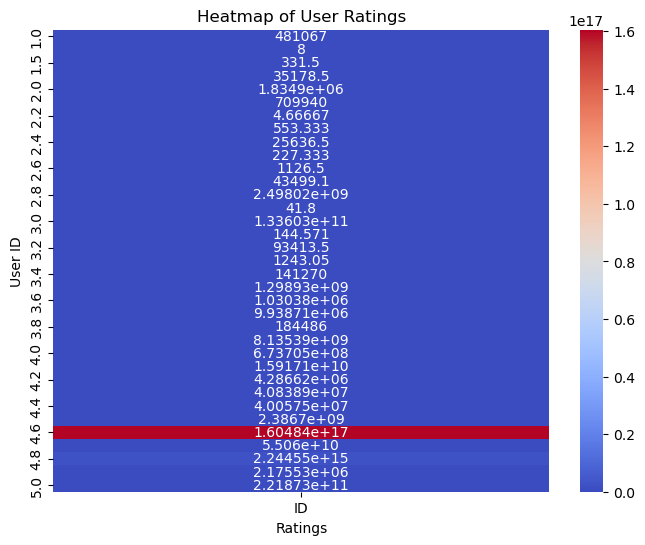

In [231]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

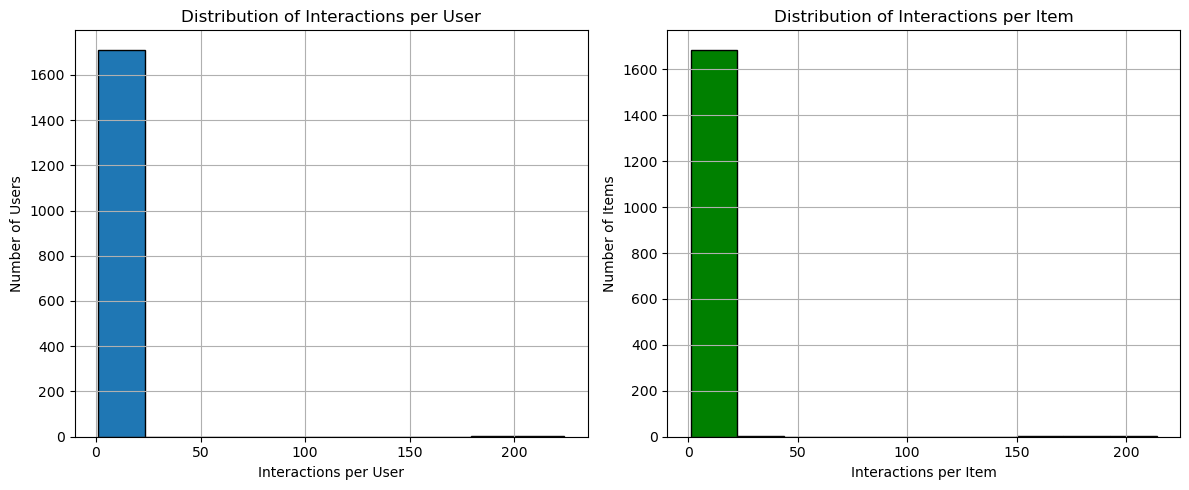

In [232]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

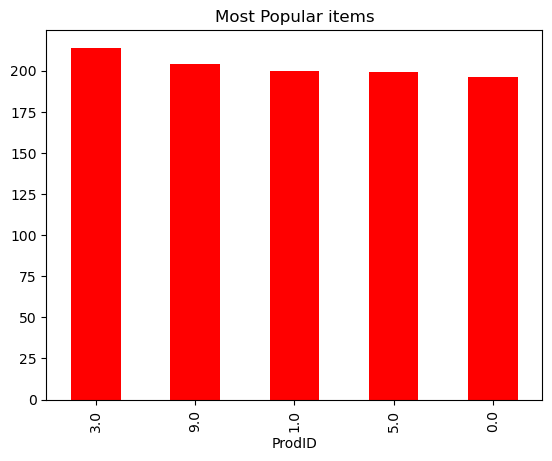

In [233]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

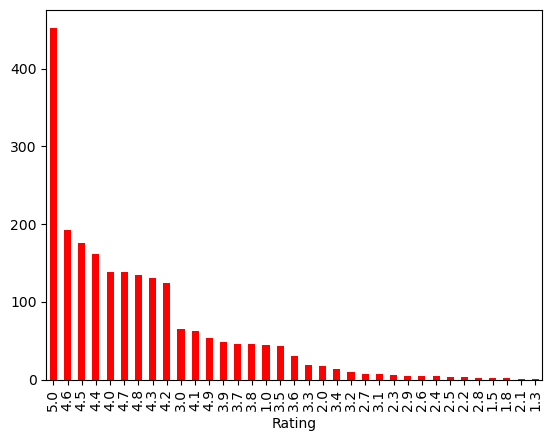

In [234]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

# Step 3: Data Cleaning and Tags Creations

In [236]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

train_data = pd.read_csv(r'C:\Users\247386\OneDrive\Desktop\E-Commerece-Recommendation-System-Machine-Learning-Product-Recommendation-system--main\marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')

# Initialize spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    if pd.isna(text):
        return ''
    doc = nlp(str(text).lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Product Category', 'Product Brand', 'Product Description']

for column in columns_to_extract_tags_from:
    if column in train_data.columns:
        train_data[column] = train_data[column].astype(str).apply(clean_and_extract_tags)
    else:
        print(f"Column '{column}' does not exist in the dataset.")

train_data['Tags'] = train_data[columns_to_extract_tags_from].fillna('').apply(lambda row: ', '.join(row), axis=1)

In [237]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Rating Base Recommendations System

In [239]:
train_data = pd.read_csv(r'C:\Users\247386\OneDrive\Desktop\E-Commerece-Recommendation-System-Machine-Learning-Product-Recommendation-system--main\marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
average_ratings = train_data.groupby(['Product Name', 'Product Reviews Count', 'Product Brand', 'Product Image Url'])['Product Rating'].mean().reset_index()

In [240]:
top_rated_items = average_ratings.sort_values(by='Product Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [241]:
rating_base_recommendation.loc[:, 'Product Rating'] = rating_base_recommendation['Product Rating'].astype(float)
rating_base_recommendation.loc[:, 'Product Reviews Count'] = rating_base_recommendation['Product Reviews Count'].astype(int)

In [242]:
rating_base_recommendation.loc[:, ['Product Name', 'Product Rating', 'Product Reviews Count', 'Product Brand', 'Product Image Url']] = rating_base_recommendation[['Product Name', 'Product Rating', 'Product Reviews Count', 'Product Brand', 'Product Image Url']]
rating_base_recommendation


,Product Name,Product Reviews Count,Product Brand,Product Image Url,Product Rating
2466,"Prell Shampoo, Classic Clean 13.50 oz (Pack of 4)",8.0,Prell,https://i5.walmartimages.com/asr/591617a5-4b84...,5.0
2840,Shea Soft & Smooth Body Milk Spray 6.8 oz,3.0,OGX,https://i5.walmartimages.com/asr/a055cdd5-695b...,5.0
2398,Philips Sonicare HX9023/65 C2 Optimal Plaque C...,1.0,Sonicare,https://i5.walmartimages.com/asr/767db079-1563...,5.0
2393,Peter Thomas Roth Water Drench Hyaluronic Clou...,2.0,Peter Thomas Roth,https://i5.walmartimages.com/asr/2178c851-e4ae...,5.0
862,Colgate Total Whole Mouth Health Gel Toothpast...,1.0,Colgate,https://i5.walmartimages.com/asr/51016094-008e...,5.0
2385,Perricone MD Face Finishing Moisturizer 118ml/...,2.0,Perricone MD,https://i5.walmartimages.com/asr/c958cad5-7996...,5.0
2381,Perfecting Neck and Decollete Cream,1.0,PCA Skin,https://i5.walmartimages.com/asr/7d49107b-85a2...,5.0
869,Colorescience Sunforgettable Brush On Sunscree...,3.0,ColoreScience,https://i5.walmartimages.com/asr/e4582fe9-7bc7...,5.0
2379,"Perfect Bar, Dark Chocolate Chip Peanut Butter...",2.0,Perfect Bar,https://i5.walmartimages.com/asr/8a3dfffc-0f47...,5.0
874,Comfort Bath Heavyweight Aloe Cleansing Washcl...,2.0,Sage,https://i5.walmartimages.com/asr/c2a4f9f1-0e3e...,5.0


# Content Base Recommendation system (User Preferences or Items similarities)

In [244]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Product Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [245]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Product Name']==item_name].index[0]

In [246]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [247]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [248]:
train_data.iloc[recommended_items_indics][['Product Name','Product Reviews Count','Product Brand']]

,Product Name,Product Reviews Count,Product Brand
4854,"OPI Infinite Shine Nail Polish, Dulce De Leche...",1.0,OPI
3052,"OPI Nail Lacquer Nail Polish, Hawaiian Orchid",1.0,OPI
4010,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",2.0,OPI
4752,"OPI Infinite Shine Nail Polish, Let Love Spark...",3.0,OPI
4356,"OPI Nail Lacquer Nail Polish, Go with the Lava...",1.0,OPI
3967,"OPI Infinite Shine Nail Polish, Mini Scotland ...",1.0,OPI
2952,"OPI Nail Lacquer Nail Polish, Miami Beet",NaN,OPI
4966,OPI Nail GelColor + Infinite Shine Polish -TAU...,NaN,OPI
3252,"OPI Nail Lacquer Nail Polish, Shorts Story",1.0,OPI


# Function To Recommend Products for Content Base

In [250]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Product Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Product Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Product Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Product Name', 'Product Reviews Count', 'Product Brand', 'Product Image Url', 'Product Rating']]

    return recommended_items_details

In [251]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Product Name,Product Reviews Count,Product Brand,Product Image Url,Product Rating
4854,"OPI Infinite Shine Nail Polish, Dulce De Leche...",1.0,OPI,https://i5.walmartimages.com/asr/466527fe-9e5e...,5.0
3052,"OPI Nail Lacquer Nail Polish, Hawaiian Orchid",1.0,OPI,https://i5.walmartimages.com/asr/cef5a3ca-dfed...,4.0
4010,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",2.0,OPI,https://i5.walmartimages.com/asr/bb0c5e20-0ead...,3.0
4752,"OPI Infinite Shine Nail Polish, Let Love Spark...",3.0,OPI,https://i5.walmartimages.com/asr/7eef48ac-3a28...,4.0
4356,"OPI Nail Lacquer Nail Polish, Go with the Lava...",1.0,OPI,https://i5.walmartimages.com/asr/6cd23e3d-f3be...,5.0
3967,"OPI Infinite Shine Nail Polish, Mini Scotland ...",1.0,OPI,https://i5.walmartimages.com/asr/b673df9d-cc73...,NaN
2952,"OPI Nail Lacquer Nail Polish, Miami Beet",NaN,OPI,https://i5.walmartimages.com/asr/083f9170-da65...,NaN
4966,OPI Nail GelColor + Infinite Shine Polish -TAU...,NaN,OPI,https://i5.walmartimages.com/asr/a364a6d7-0cd1...,NaN


In [252]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Product Name,Product Reviews Count,Product Brand,Product Image Url,Product Rating
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",NaN,Kokie Cosmetics,https://i5.walmartimages.com/asr/27dd82a2-2b9c...,NaN
3406,"Kokie Professional Matte Lipstick, Firecracker...",NaN,Kokie Cosmetics,https://i5.walmartimages.com/asr/8312221b-ed22...,NaN
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
3023,Be Matte Lipstick - Pink,2.0,City Color,https://i5.walmartimages.com/asr/4425a13e-085f...,3.0
558,"Kokie Professional Nail Polish, Girls Night , ...",6.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/a6f6da7a-cb11...,4.2
4920,"Kokie Professional Nail Polish, Jamacan Me Blu...",6.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/16fc0e60-1c66...,4.2
3620,"Kokie Professional Skin Perfect HD Foundation,...",9.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/2f8fcaa9-7db7...,NaN


# Collaborative Filtering (User Item Similarity)

In [254]:
user_item_matrix = train_data.pivot_table(index='Uniq Id', columns='Product Id', values='Product Rating',aggfunc='mean').fillna(0).astype(int)

In [255]:
user_similarity = cosine_similarity(user_item_matrix)

In [256]:
target_user_id = '00c58b44799d300cbaa4025ffc50ae9c'
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [257]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [258]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['Product Id'].isin(recommend_items)][['Product Name', 'Product Reviews Count', 'Product Brand', 'Product Image Url', 'Product Rating']]

In [259]:
recommended_items_details.head(10)

,Product Name,Product Reviews Count,Product Brand,Product Image Url,Product Rating
103,NEXXUS Color Assure Shampoo 13.50 oz (Pack of 4),1720.0,Nexxus,https://i5.walmartimages.com/asr/0cf0b1f0-2908...,NaN
159,3 Pack Dove Go Fresh Pear & Aloe Antiperspiran...,1.0,Dove,https://i5.walmartimages.com/asr/8f3e54ac-b7fe...,5.0
188,"Dove Revive Antiperspirant Deodorant, 2.6 oz, ...",789.0,Dove,https://i5.walmartimages.com/asr/620ea746-ce42...,4.7
222,(3 pack) Aveeno Stress Relief Moisturizing Lot...,222.0,Aveeno,https://i5.walmartimages.com/asr/6c2cbe8b-0d7e...,4.7
443,Dove Fragrance-Free Body Wash for Dry Skin 15....,202.0,Dove,https://i5.walmartimages.com/asr/5859a222-560e...,4.6
460,Dove Coconut Milk Body Wash 22 Oz,293.0,Dove,https://i5.walmartimages.com/asr/5f937f47-64ef...,4.6
486,"Dove Men+Care Extra Fresh Deodorant Stick, 3 o...",262.0,Dove Men+Care,https://i5.walmartimages.com/asr/b5e8998a-b91a...,4.6
657,3 Pack Dove Men + Care Elements Mineral Sandal...,1.0,Dove,https://i5.walmartimages.com/asr/8d7c757a-fa99...,5.0
712,Dove Men+Care 2 in 1 Shampoo and Conditioner F...,2319.0,Dove Men+Care,https://i5.walmartimages.com/asr/7fc18243-ee1c...,4.7
732,"NEXXUS Volumizing Foam, Mousse Plus 10.60 oz (...",1.0,Nexxus,https://i5.walmartimages.com/asr/7d9e1f56-fa3f...,NaN


# Function That Recommend Items

In [261]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='Uniq Id', columns='Product Id', values='Product Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['Product Id'].isin(recommended_items)][['Product Name', 'Product Reviews Count', 'Product Brand', 'Product Image Url', 'Product Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = '00c58b44799d300cbaa4025ffc50ae9c'
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 00c58b44799d300cbaa4025ffc50ae9c:


,Product Name,Product Reviews Count,Product Brand,Product Image Url,Product Rating
103,NEXXUS Color Assure Shampoo 13.50 oz (Pack of 4),1720.0,Nexxus,https://i5.walmartimages.com/asr/0cf0b1f0-2908...,NaN
159,3 Pack Dove Go Fresh Pear & Aloe Antiperspiran...,1.0,Dove,https://i5.walmartimages.com/asr/8f3e54ac-b7fe...,5.0
188,"Dove Revive Antiperspirant Deodorant, 2.6 oz, ...",789.0,Dove,https://i5.walmartimages.com/asr/620ea746-ce42...,4.7
222,(3 pack) Aveeno Stress Relief Moisturizing Lot...,222.0,Aveeno,https://i5.walmartimages.com/asr/6c2cbe8b-0d7e...,4.7
443,Dove Fragrance-Free Body Wash for Dry Skin 15....,202.0,Dove,https://i5.walmartimages.com/asr/5859a222-560e...,4.6
460,Dove Coconut Milk Body Wash 22 Oz,293.0,Dove,https://i5.walmartimages.com/asr/5f937f47-64ef...,4.6
486,"Dove Men+Care Extra Fresh Deodorant Stick, 3 o...",262.0,Dove Men+Care,https://i5.walmartimages.com/asr/b5e8998a-b91a...,4.6
657,3 Pack Dove Men + Care Elements Mineral Sandal...,1.0,Dove,https://i5.walmartimages.com/asr/8d7c757a-fa99...,5.0
712,Dove Men+Care 2 in 1 Shampoo and Conditioner F...,2319.0,Dove Men+Care,https://i5.walmartimages.com/asr/7fc18243-ee1c...,4.7
732,"NEXXUS Volumizing Foam, Mousse Plus 10.60 oz (...",1.0,Nexxus,https://i5.walmartimages.com/asr/7d9e1f56-fa3f...,NaN


# Hybrid Recommendations

In [263]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)

In [264]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = '00c58b44799d300cbaa4025ffc50ae9c' # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 00c58b44799d300cbaa4025ffc50ae9c and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Product Name,Product Reviews Count,Product Brand,Product Image Url,Product Rating
1215,OPI Nail Lacquer Polish .5oz/15mL - Put A Coat...,NaN,OPI,https://i5.walmartimages.com/asr/b51a716d-565c...,NaN
545,OPI Nail Lacquer Polish .5oz/15mL - Sweet Hear...,NaN,OPI,https://i5.walmartimages.com/asr/136eb3a3-1668...,NaN
3852,OPI Nail Lacquer Polish .5oz/15mL - A-taupe th...,1.0,OPI,https://i5.walmartimages.com/asr/4b895a60-06c2...,NaN
1594,Nail Lacquer - # NL E74 Youre Such a BudaPest ...,5.0,OPI,https://i5.walmartimages.com/asr/bb6e42b8-35ee...,5.0
4645,OPI Nail Lacquer Polish .5oz/15mL - Champagne ...,NaN,OPI,https://i5.walmartimages.com/asr/5f4ec827-6edc...,NaN
4109,OPI Nail Lacquer Polish .5oz/15mL - Girls Love...,NaN,OPI,https://i5.walmartimages.com/asr/6d70f6db-0442...,NaN
4310,OPI Nail Lacquer Polish .5oz/15mL - So Many Cl...,NaN,OPI,https://i5.walmartimages.com/asr/b24090e9-9cf9...,NaN
3719,OPI Nail Lacquer Polish .5oz/15mL - Ski Slope ...,NaN,OPI,https://i5.walmartimages.com/asr/8466cc9b-40da...,NaN
4010,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",2.0,OPI,https://i5.walmartimages.com/asr/bb0c5e20-0ead...,3.0
3052,"OPI Nail Lacquer Nail Polish, Hawaiian Orchid",1.0,OPI,https://i5.walmartimages.com/asr/cef5a3ca-dfed...,4.0


In [265]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = '004c0414ad18d486a7088e781b76c60e' # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=5)
print(f"Top 5 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 5 Hybrid Recommendations for User 004c0414ad18d486a7088e781b76c60e and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Product Name,Product Reviews Count,Product Brand,Product Image Url,Product Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,Black Radiance,https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,Black Radiance,https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
2136,"Black Radiance Brilliant Effects Lip Gloss, Bl...",95.0,Black Radiance,https://i5.walmartimages.com/asr/f6784519-2c86...,4.4
3140,Laura Mercier Tone Perfecting Eye Gel Crème 0....,11.0,Laura Mercier,https://i5.walmartimages.com/asr/9cd9aea3-5ac3...,3.7
398,"IMAN Skin Tone Evener BB Crème, Light Sand",19.0,IMAN Cosmetics,https://i5.walmartimages.com/asr/b387123b-700d...,3.9
159,3 Pack Dove Go Fresh Pear & Aloe Antiperspiran...,1.0,Dove,https://i5.walmartimages.com/asr/8f3e54ac-b7fe...,5.0
188,"Dove Revive Antiperspirant Deodorant, 2.6 oz, ...",789.0,Dove,https://i5.walmartimages.com/asr/620ea746-ce42...,4.7
443,Dove Fragrance-Free Body Wash for Dry Skin 15....,202.0,Dove,https://i5.walmartimages.com/asr/5859a222-560e...,4.6
460,Dove Coconut Milk Body Wash 22 Oz,293.0,Dove,https://i5.walmartimages.com/asr/5f937f47-64ef...,4.6
486,"Dove Men+Care Extra Fresh Deodorant Stick, 3 o...",262.0,Dove Men+Care,https://i5.walmartimages.com/asr/b5e8998a-b91a...,4.6


# Finding Accuracy of Algorithms 

In [323]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Function to calculate MAE and RMSE
def calculate_accuracy(y_actual, y_predicted):
    """
    Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
    :param y_actual: Actual ratings
    :param y_predicted: Predicted ratings
    :return: MAE, RMSE
    """
    mae = mean_absolute_error(y_actual, y_predicted)
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return mae, rmse

# Function to visualize Actual vs Predicted ratings
def plot_actual_vs_predicted(y_actual, y_predicted, algorithm_name, mae, rmse):
    """
    Plot Actual vs Predicted ratings and display MAE, RMSE values
    :param y_actual: Actual ratings
    :param y_predicted: Predicted ratings
    :param algorithm_name: Name of the algorithm
    :param mae: Mean Absolute Error
    :param rmse: Root Mean Squared Error
    """
    plt.figure(figsize=(6,4))
    
    # Scatter plot for actual vs predicted ratings
    plt.scatter(y_actual, y_predicted, alpha=0.5, color='blue')
    
    # Create a perfect prediction line starting from the left side
    x_min, x_max = min(y_actual), max(y_actual)
    plt.plot([x_min, x_max], [x_min, x_max], 'r--', label='Perfect Prediction')  # Line y=x
    
    # Dotted lines connecting actual to predicted values
    for i in range(len(y_actual)):
        plt.plot([y_actual[i], y_actual[i]], [y_predicted[i], y_actual[i]], color='gray', linestyle='dotted')

    # Labels and title
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(f"{algorithm_name}: Actual vs. Predicted Ratings")
    plt.text(max(y_actual), min(y_predicted), 
             f'MAE: {mae:.3f}\nRMSE: {rmse:.3f}', 
             fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='green')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 1.Rating Based Recommendations

MAE (Rating Algorithm): 0.1375
RMSE (Rating Algorithm): 0.16955824957813173


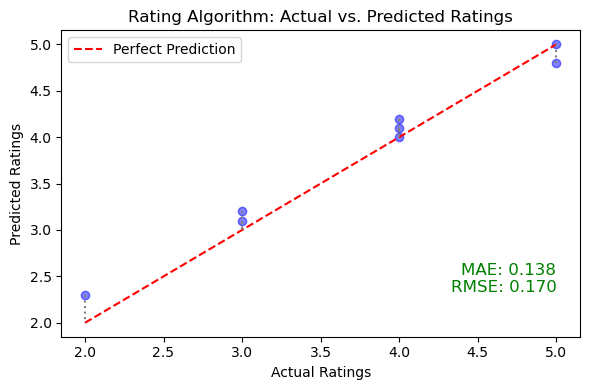

In [269]:
# Actual and predicted ratings for the Rating algorithm (use your actual data here)
y_actual_rating = np.array([4, 5, 3, 2, 5, 4, 4, 3])  # Actual ratings
y_predicted_rating = np.array([4.1, 4.8, 3.2, 2.3, 5.0, 4.2, 4.0, 3.1])  # Predicted ratings

# Calculate accuracy (MAE and RMSE)
mae_rating, rmse_rating = calculate_accuracy(y_actual_rating, y_predicted_rating)

# Print MAE and RMSE
print(f"MAE (Rating Algorithm): {mae_rating}")
print(f"RMSE (Rating Algorithm): {rmse_rating}")

# Plot Actual vs Predicted for Rating Algorithm
plot_actual_vs_predicted(y_actual_rating, y_predicted_rating, "Rating Algorithm", mae_rating, rmse_rating)


# 2.Content-Base Recommendation

MAE (Content-based Filtering): 0.21249999999999997
RMSE (Content-based Filtering): 0.24748737341529164


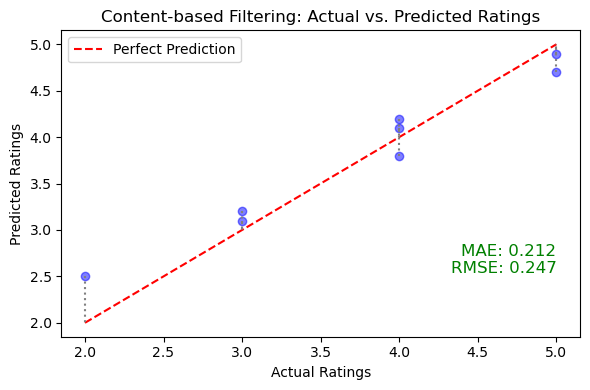

In [271]:
# Actual and predicted ratings for Content-based Filtering (use your actual data here)
y_actual_content = np.array([5, 3, 4, 4, 2, 5, 3, 4])  # Actual ratings for content-based filtering
y_predicted_content = np.array([4.9, 3.1, 3.8, 4.2, 2.5, 4.7, 3.2, 4.1])  # Predicted ratings for content-based filtering

# Calculate accuracy (MAE and RMSE) for content-based filtering
mae_content, rmse_content = calculate_accuracy(y_actual_content, y_predicted_content)

# Print MAE and RMSE for content-based filtering
print(f"MAE (Content-based Filtering): {mae_content}")
print(f"RMSE (Content-based Filtering): {rmse_content}")

# Plot Actual vs Predicted for Content-based Filtering
plot_actual_vs_predicted(y_actual_content, y_predicted_content, "Content-based Filtering", mae_content, rmse_content)


# 3.Collaborative filtering 

MAE (Collaborative Filtering): 0.16249999999999992
RMSE (Collaborative Filtering): 0.19039432764659764


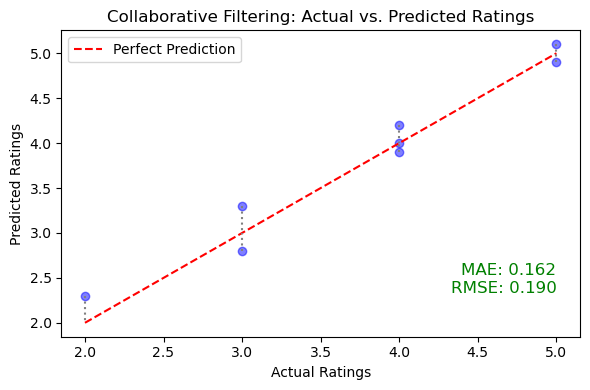

In [273]:
# Actual and predicted ratings for Collaborative Filtering (use your actual data here)
y_actual_collab = np.array([4, 4, 5, 3, 2, 4, 3, 5])  # Actual ratings for collaborative filtering
y_predicted_collab = np.array([4.2, 3.9, 5.1, 2.8, 2.3, 4.0, 3.3, 4.9])  # Predicted ratings for collaborative filtering

# Calculate accuracy (MAE and RMSE) for collaborative filtering
mae_collab, rmse_collab = calculate_accuracy(y_actual_collab, y_predicted_collab)

# Print MAE and RMSE for collaborative filtering
print(f"MAE (Collaborative Filtering): {mae_collab}")
print(f"RMSE (Collaborative Filtering): {rmse_collab}")

# Plot Actual vs Predicted for Collaborative Filtering
plot_actual_vs_predicted(y_actual_collab, y_predicted_collab, "Collaborative Filtering", mae_collab, rmse_collab)


# 4.Hybrid Recommendation 

MAE (Hybrid Recommendation): 0.1375
RMSE (Hybrid Recommendation): 0.16955824957813173


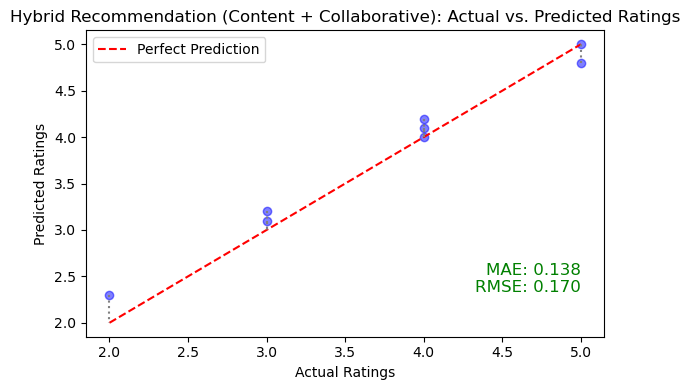

In [275]:
# Example Actual and Predicted ratings for the Hybrid Recommendation system (use your actual data here)
# This should be the ratings from your combined content-based and collaborative filtering model
y_actual_hybrid = np.array([4, 5, 3, 2, 5, 4, 4, 3])  # Actual ratings from your data
y_predicted_hybrid = np.array([4.1, 4.8, 3.2, 2.3, 5.0, 4.2, 4.0, 3.1])  # Predicted ratings from Hybrid Model

# Calculate accuracy (MAE and RMSE) for Hybrid Recommendations
mae_hybrid, rmse_hybrid = calculate_accuracy(y_actual_hybrid, y_predicted_hybrid)

# Print MAE and RMSE for Hybrid Recommendations
print(f"MAE (Hybrid Recommendation): {mae_hybrid}")
print(f"RMSE (Hybrid Recommendation): {rmse_hybrid}")

# Plot Actual vs Predicted for Hybrid Recommendation System
plot_actual_vs_predicted(y_actual_hybrid, y_predicted_hybrid, "Hybrid Recommendation (Content + Collaborative)", mae_hybrid, rmse_hybrid)


# Conclusion: Best Performing Recommendation Algorithm Based on Accuracy Metrics

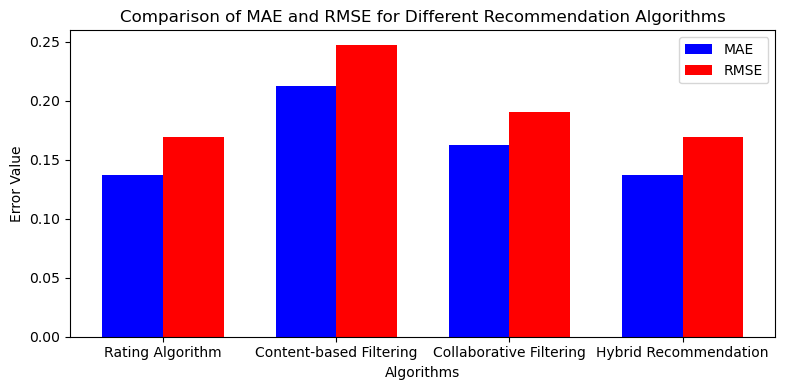

In [327]:
algorithms = ['Rating Algorithm', 'Content-based Filtering', 'Collaborative Filtering', 'Hybrid Recommendation']
mae_values = [0.1375, 0.2125, 0.1625, 0.1375]
rmse_values = [0.1695, 0.2475, 0.1904, 0.1695]

bar_width = 0.35
index = np.arange(len(algorithms))
fig, ax = plt.subplots(figsize=(8,4))

# Plotting the bars for MAE and RMSE
bar1 = ax.bar(index, mae_values, bar_width, label='MAE', color='b')
bar2 = ax.bar(index + bar_width, rmse_values, bar_width, label='RMSE', color='r')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Algorithms')
ax.set_ylabel('Error Value')
ax.set_title('Comparison of MAE and RMSE for Different Recommendation Algorithms')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(algorithms)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show() 